In [1]:
from pipeline import Pipeline, Process, Postprocess, Preprocess
import numpy as np
import pandas as pd

In [2]:
class MyPreProcess(Preprocess):
    process_desc = "Exemple de pre-process -> ne fait rien"
    # prends en param la liste d'images
    def run(self, images):
        pass


class MyProcess(Process):
    process_desc = "Exemple de process -> ne fait rien"
    def run(self, images):
        pass
    
    
class MyPostProcess(Postprocess):
    process_desc = "Exemple de post-process -> ne fait rien"
    def run(self, images):
        pass

In [3]:
pipeline = Pipeline()
process_array = np.array([MyPreProcess()
                          ,MyProcess()
                          ,MyPostProcess()
                          ,MyPreProcess(verbose=0)])
pipeline.add_processes(process_array)

Preprocess :  Exemple de pre-process -> ne fait rien
Process :  Exemple de process -> ne fait rien
Postprocess :  Exemple de post-process -> ne fait rien
Exemple de pre-process -> ne fait rien a été ajouté.
Exemple de process -> ne fait rien a été ajouté.
Exemple de post-process -> ne fait rien a été ajouté.
Exemple de pre-process -> ne fait rien a été ajouté.


In [4]:
pipeline.print_process()

Exemple de pre-process -> ne fait rien
Exemple de pre-process -> ne fait rien
Exemple de process -> ne fait rien
Exemple de post-process -> ne fait rien


In [5]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import pandas as pd

data_path = "/home/sid2019-1/Documents/M2_DATA_INTERPROMO/"

# Helpful Functions  (cf.Cyril GAILLARD)

In [6]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def longestValue(inputList):
    if len(inputList) > 0:
        max_len = 0
        for i, el in enumerate(inputList):
            if len(el) > max_len:
                max_len = i
        return inputList[max_len]
    return 0

def get_relevant_aircraft_builders(image_names, proportion_min=0.02, proportion_max=0.75):
    # retrieve aircraft types
    aircraft_builders = np.unique([a_type.split(' ')[0].lower() for a_type in pd.read_csv(data_path + 'SEATGURU_INFO_AIRCRAFT.csv', sep=';')['Aircraft_Type'].tolist() if len(a_type.split(' ')) > 1])
    
    # remove aircraft_builder that have Numerics in it
    aircraft_builders = [a_builder for a_builder in  aircraft_builders if not hasNumbers(a_builder) and len(a_builder) > 2]
    
    # remove aircraft with too low occurences in the "IMAGES_NAMES" list
    relevant_aircraft_builders = {}
    for a_builder in aircraft_builders:
        proportion = sum([1for img_n in image_names if a_builder in img_n.lower()]) / len(image_names)
        if proportion > proportion_min and proportion < proportion_max:
            relevant_aircraft_builders[a_builder] = proportion

    # remove non aircradft builder that remain
    del relevant_aircraft_builders['airlines']
    del relevant_aircraft_builders['irbus']
    del relevant_aircraft_builders['airways']
    del relevant_aircraft_builders['ays']

    
    # sort by proportion
    relevant_aircraft_builders = {k: v for k, v in sorted(relevant_aircraft_builders.items(), key=lambda item: item[1])}
    return relevant_aircraft_builders

def get_airline_aircraft_builder_pos(image_names, aircraft_builders, airlines, aircraft_ref, pattern):
    # Initialisation of dict
    dictio_airlines_aircraft_builders = []
        
    for image_name in image_names:
        dictio_airlines_aircraft_builders.append({
            'image_name': image_name,
            'aircraft_builder': '', 
            'position_aircraft_builder': -1, 
            'airline': '',
            'aircraft_ref': []
        })
        
        last_el = len(dictio_airlines_aircraft_builders) - 1
        # initiliase position
        position = -1
        # a little pre-process to clean-up image name
        img_inf = image_name.lower().split('.')[0].split(pattern)

        for i, item in enumerate(img_inf):
            for a_builder in aircraft_builders:
                # check if the image contains the aircraft builder
                if a_builder == item:
                    # add the aircraft builder in the image name
                    position = i
                    dictio_airlines_aircraft_builders[last_el]['aircraft_builder'] = a_builder
                    
        if position == -1: dictio_airlines_aircraft_builders[last_el]['aircraft_builder'] = 'not_relevant_aircraft_builders'
        dictio_airlines_aircraft_builders[last_el]['position_aircraft_builder'] = position
        
        # add airlines deduce by the image name
        for airline in airlines:
            if airline + pattern in image_name.lower():
                dictio_airlines_aircraft_builders[last_el]['airline'] = airline
                
        # add aircraft_ref
        for a_ref in aircraft_ref:
            if a_ref in  image_name.lower():
                 dictio_airlines_aircraft_builders[last_el]['aircraft_ref'].append(a_ref)
        # take the longest str element in the list of ref
        dictio_airlines_aircraft_builders[last_el]['aircraft_ref'] = longestValue(dictio_airlines_aircraft_builders[last_el]['aircraft_ref'])
    
    return dictio_airlines_aircraft_builders

# LAYOUT SEATGURU

In [7]:
def main_layout_seatguru(layout):
    images = [data_path + layout + img for img in os.listdir(data_path + layout)]
    IMAGE_NAMES = [img for img in os.listdir(data_path + layout)]
    
    relevant_aircraft_builders = get_relevant_aircraft_builders(IMAGE_NAMES)
    airlines = pd.read_csv(data_path + 'SEATGURU_INFO_AIRCRAFT.csv', sep=';')['Airline_name'].unique()
    airlines = [airline.replace('-','_') for airline in airlines] 

    aircraft_ref = np.unique([a_type.lower() for a_type in pd.read_csv(data_path + 'SEATGURU_INFO_AIRCRAFT.csv', sep=';')['Aircraft_Type'].tolist()])
    aircraft_ref = np.unique([t for text in aircraft_ref  for t in text.split(' ') if hasNumbers(t)])
    
    dictio_airlines_aircraft_builders = get_airline_aircraft_builder_pos(IMAGE_NAMES, relevant_aircraft_builders, airlines, aircraft_ref, '_')
    return pd.DataFrame(dictio_airlines_aircraft_builders)

layout = "LAYOUT_SEATGURU/"
df_layout_seatguru = main_layout_seatguru(layout)
df_layout_seatguru[df_layout_seatguru['aircraft_ref'] == 'a350']

,aircraft_builder,aircraft_ref,airline,image_name,position_aircraft_builder
522,airbus,a350,qatar_airways,Qatar_Airways_Airbus_A350_plane732.svg.png,2
674,not_relevant_aircraft_builders,a350,,Philipine_Airlines_A350_plane703.svg.png,-1


# LAYOUT SEATMAESTRO

In [8]:
def main_layout_seatguru(layout):
    images = [data_path + layout + img for img in os.listdir(data_path + layout)]
    IMAGE_NAMES = [img for img in os.listdir(data_path + layout)]
    
    relevant_aircraft_builders = get_relevant_aircraft_builders(IMAGE_NAMES)
    airlines = pd.read_csv(data_path + 'SEATGURU_INFO_AIRCRAFT.csv', sep=';')['Airline_name'].unique()

    aircraft_ref = np.unique([a_type.lower() for a_type in pd.read_csv(data_path + 'SEATGURU_INFO_AIRCRAFT.csv', sep=';')['Aircraft_Type'].tolist()])
    aircraft_ref = np.unique([t for text in aircraft_ref  for t in text.split(' ') if hasNumbers(t)])
    
    dictio_airlines_aircraft_builders = get_airline_aircraft_builder_pos(IMAGE_NAMES, relevant_aircraft_builders, airlines, aircraft_ref, '-')
    return pd.DataFrame(dictio_airlines_aircraft_builders)

layout = "LAYOUT_SEATMAESTRO/"
df_layout_seatmaestro = main_layout_seatguru(layout)
df_layout_seatmaestro[df_layout_seatmaestro['aircraft_ref'] == 'a350']

,aircraft_builder,aircraft_ref,airline,image_name,position_aircraft_builder
293,airbus,a350,vietnam-airlines,vietnam-airlines-airbus-a350-config-1.png,2
573,airbus,a350,vietnam-airlines,vietnam-airlines-airbus-a350-config-2.png,2
938,airbus,a350,,latam-airlines-brasil-airbus-a350.png,3


In [9]:
df_layout_seatguru['image_name'].tolist()[0]

'Qatar_Airways_Boeing_777-300ER_plane737.svg.png'

# FIRST PRE-PROCESS

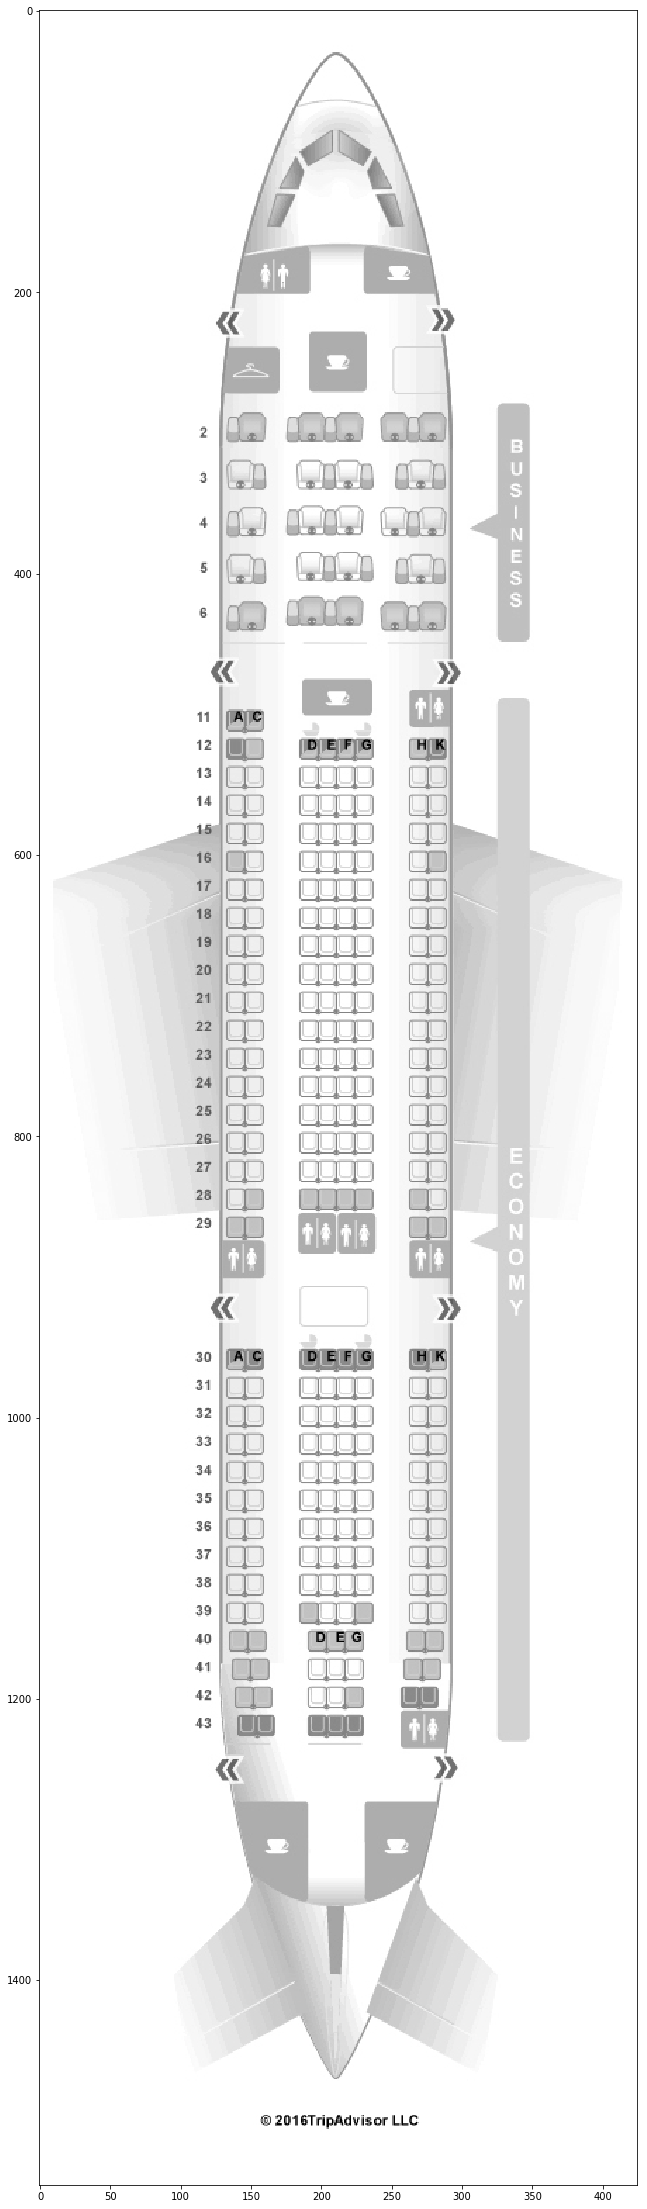

In [10]:
layout = "LAYOUT_SEATGURU/"
data_path = "/home/sid2019-1/Documents/M2_DATA_INTERPROMO/"

img = plt.imread(data_path + layout + df_layout_seatguru[df_layout_seatguru['image_name'] == 'Aer_Lingus_Airbus_A330-200_plane4.jpg']['image_name'].tolist()[0])
imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.figure(figsize=(20,40))
plt.imshow(imgray, cmap='gray')

## Erosion

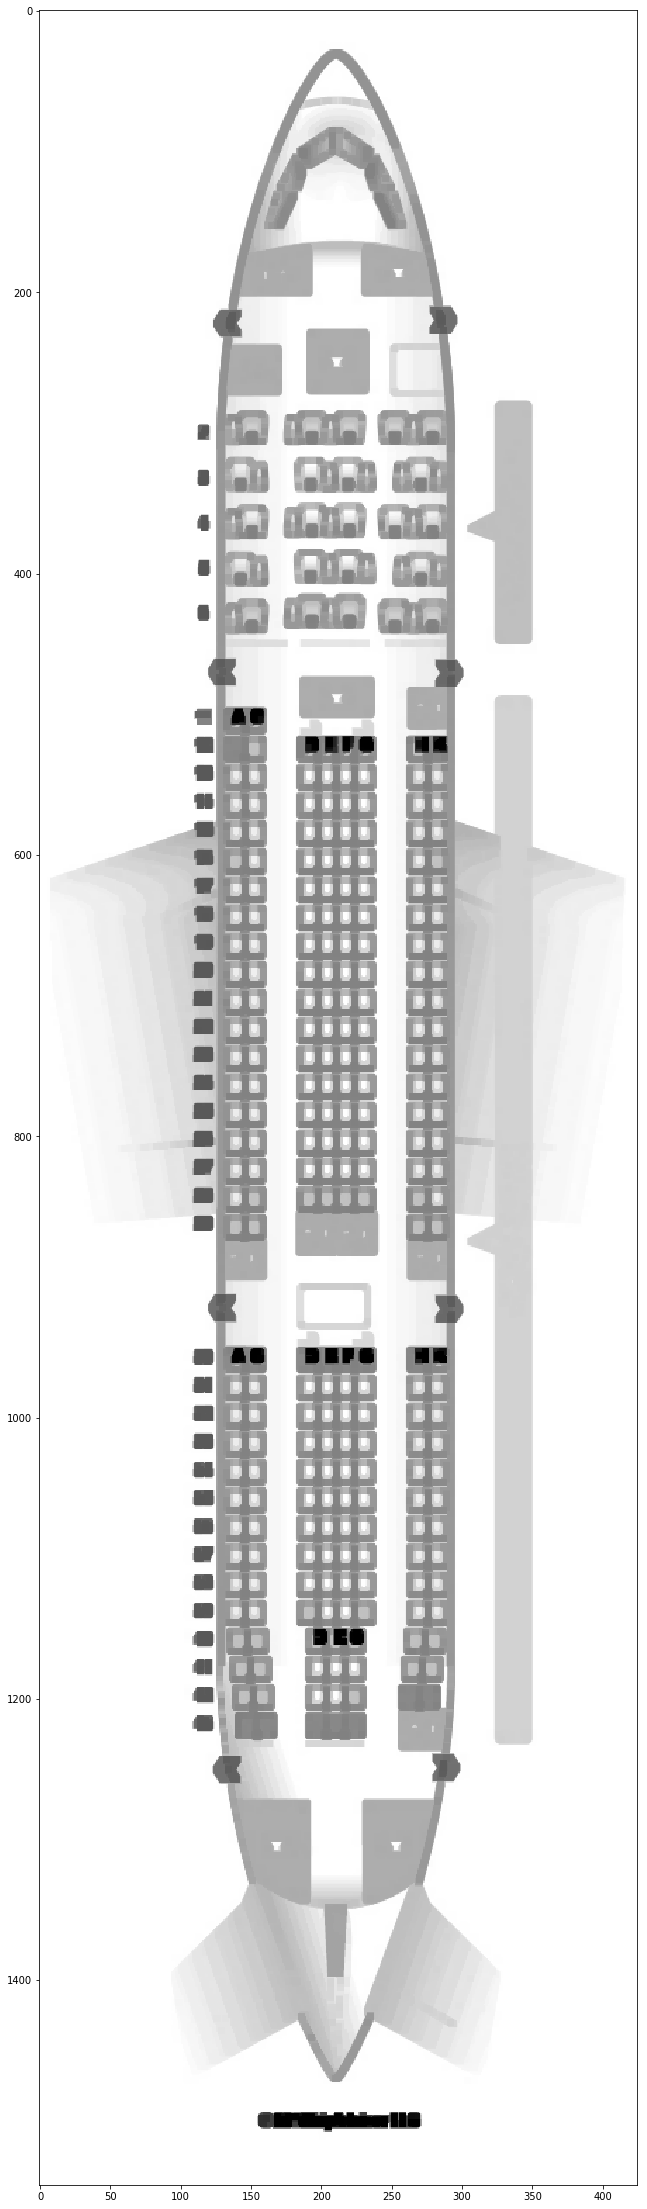

In [11]:
kernel = np.ones((5,5),np.uint8)
erosion = cv.erode(imgray,kernel,iterations = 1)
plt.figure(figsize=(20,40))
plt.imshow(erosion, cmap='gray')

## Dilation

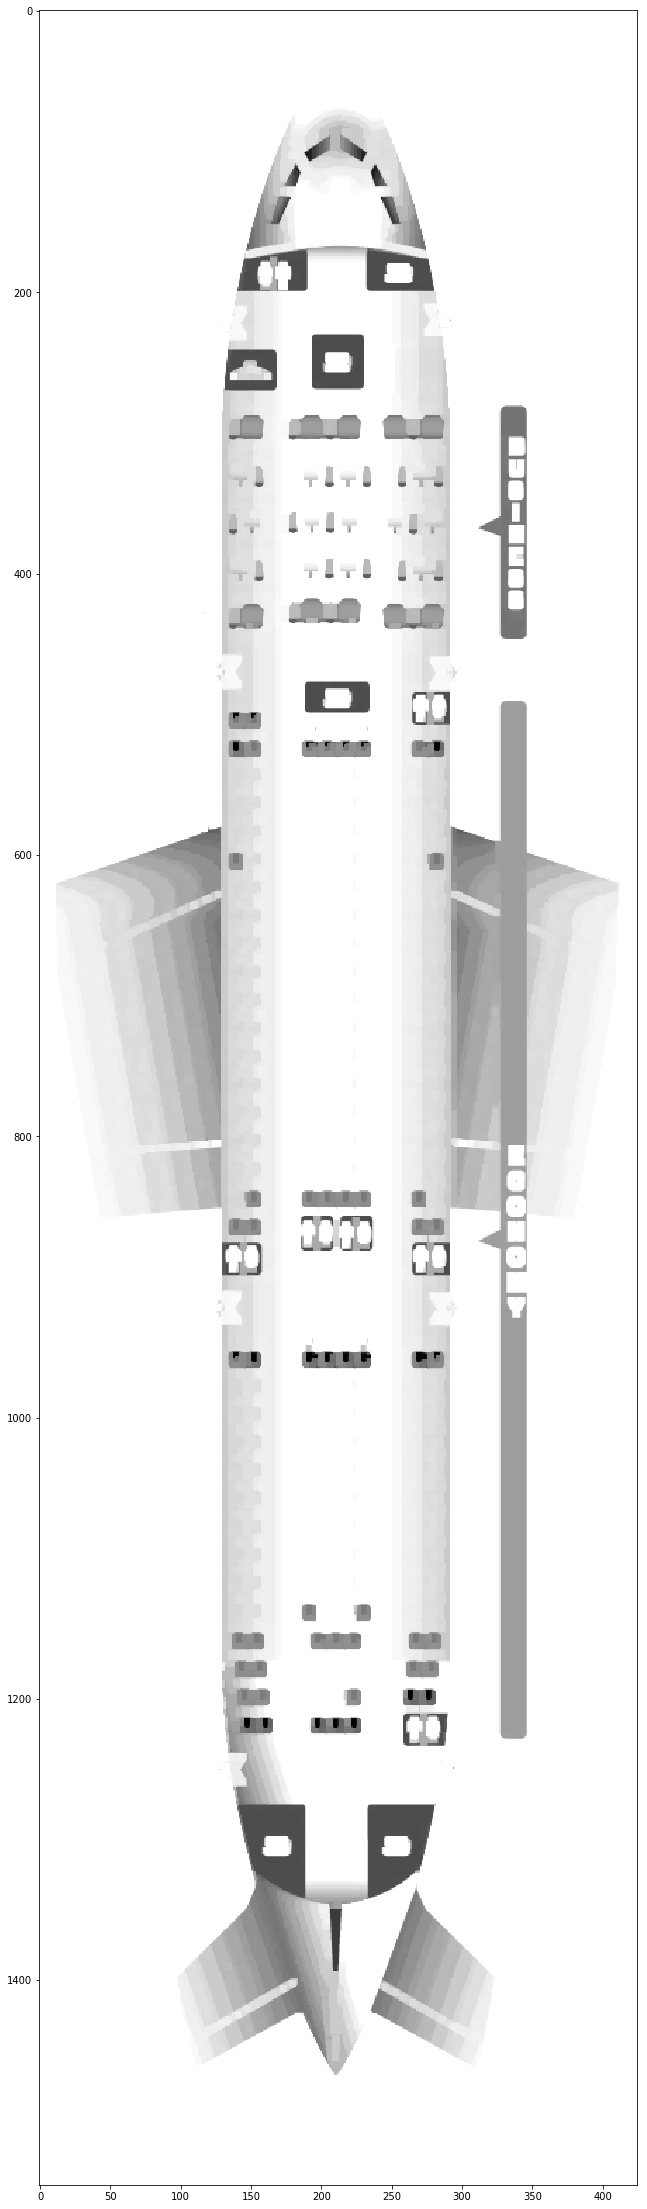

In [12]:
kernel = np.ones((5,5),np.uint8)
dilation = cv.dilate(imgray,kernel,iterations = 1)
plt.figure(figsize=(20,40))
plt.imshow(dilation, cmap='gray')

## Opening

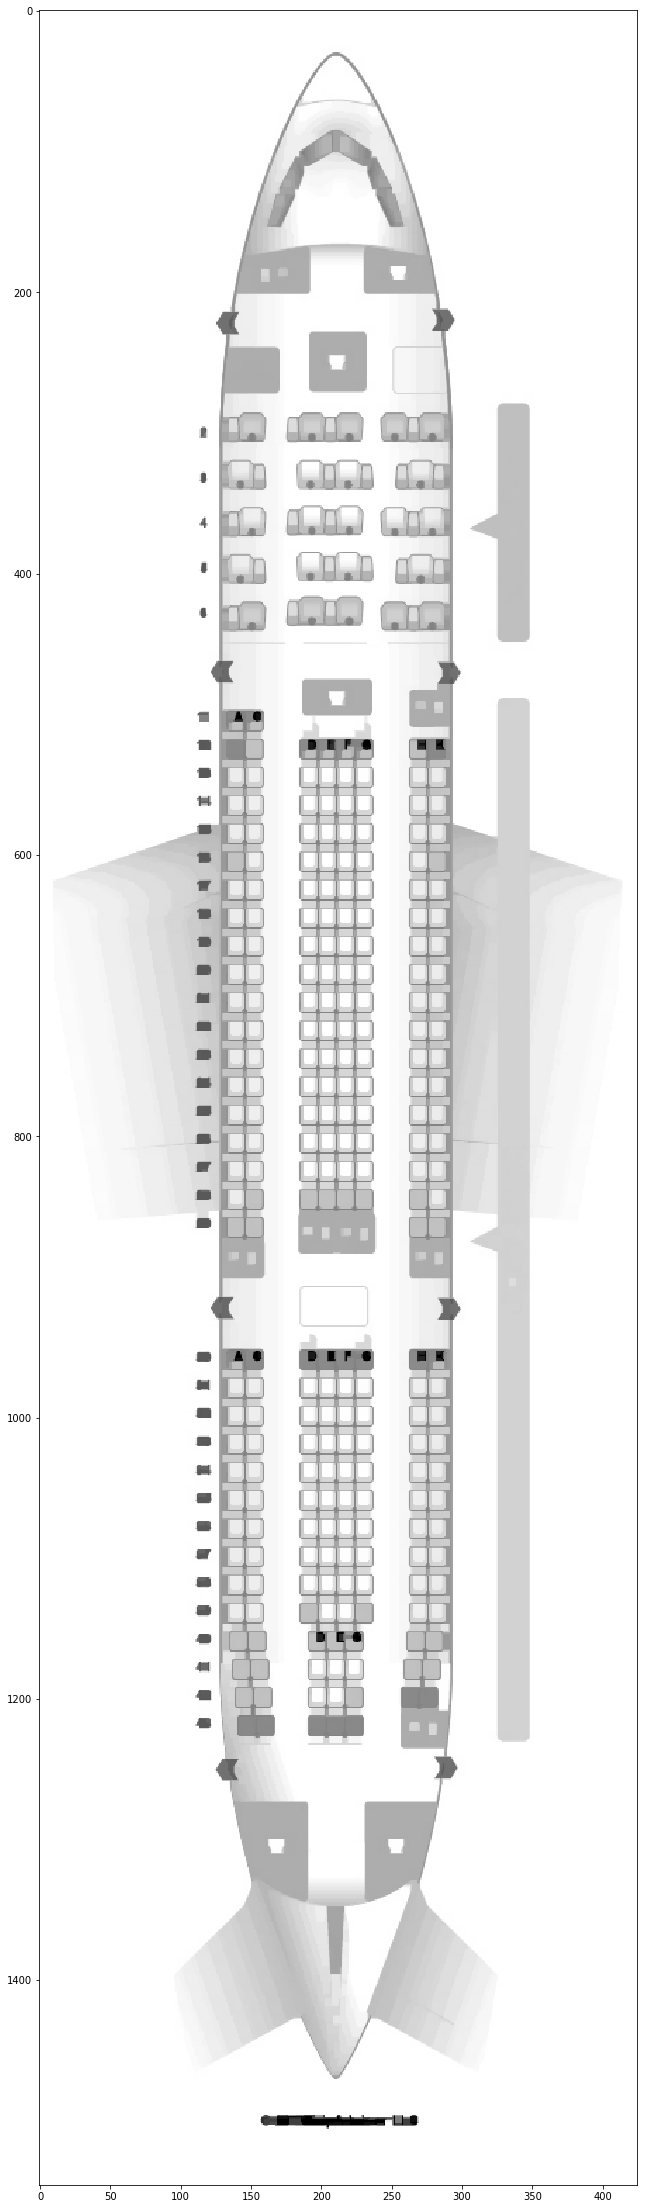

In [13]:
kernel = np.ones((5,5),np.uint8)
opening = cv.morphologyEx(imgray, cv.MORPH_OPEN, kernel)
plt.figure(figsize=(20,40))
plt.imshow(opening, cmap='gray')

## Closing

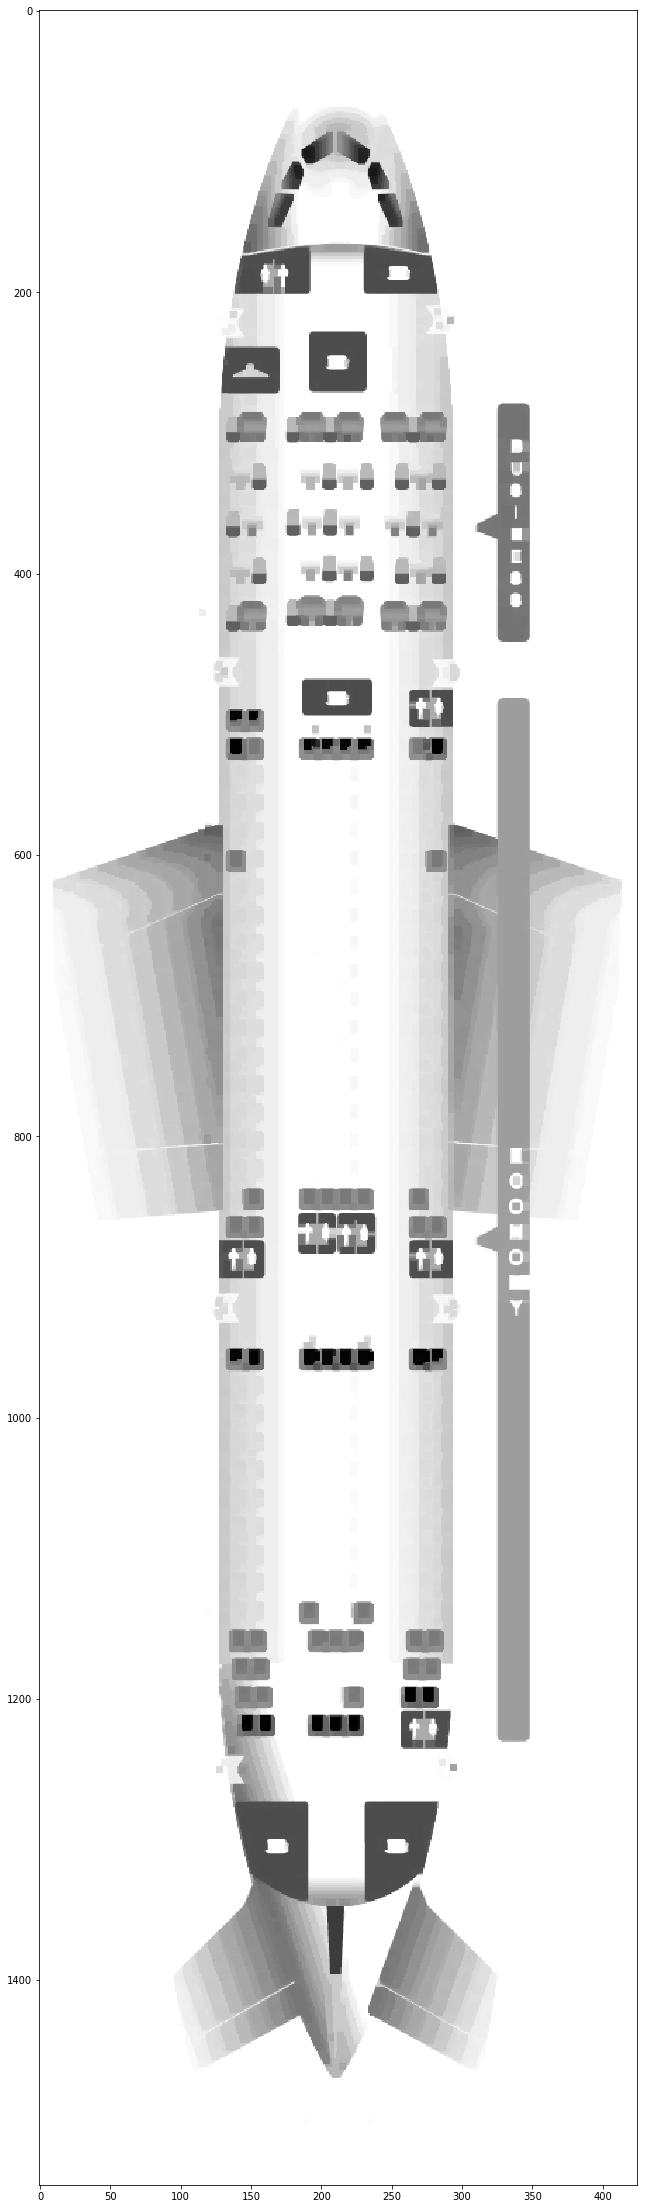

In [14]:
kernel = np.ones((5,5),np.uint8)
closing = cv.morphologyEx(imgray, cv.MORPH_CLOSE, kernel)
plt.figure(figsize=(20,40))
plt.imshow(closing, cmap='gray')

## Morphological Gradient

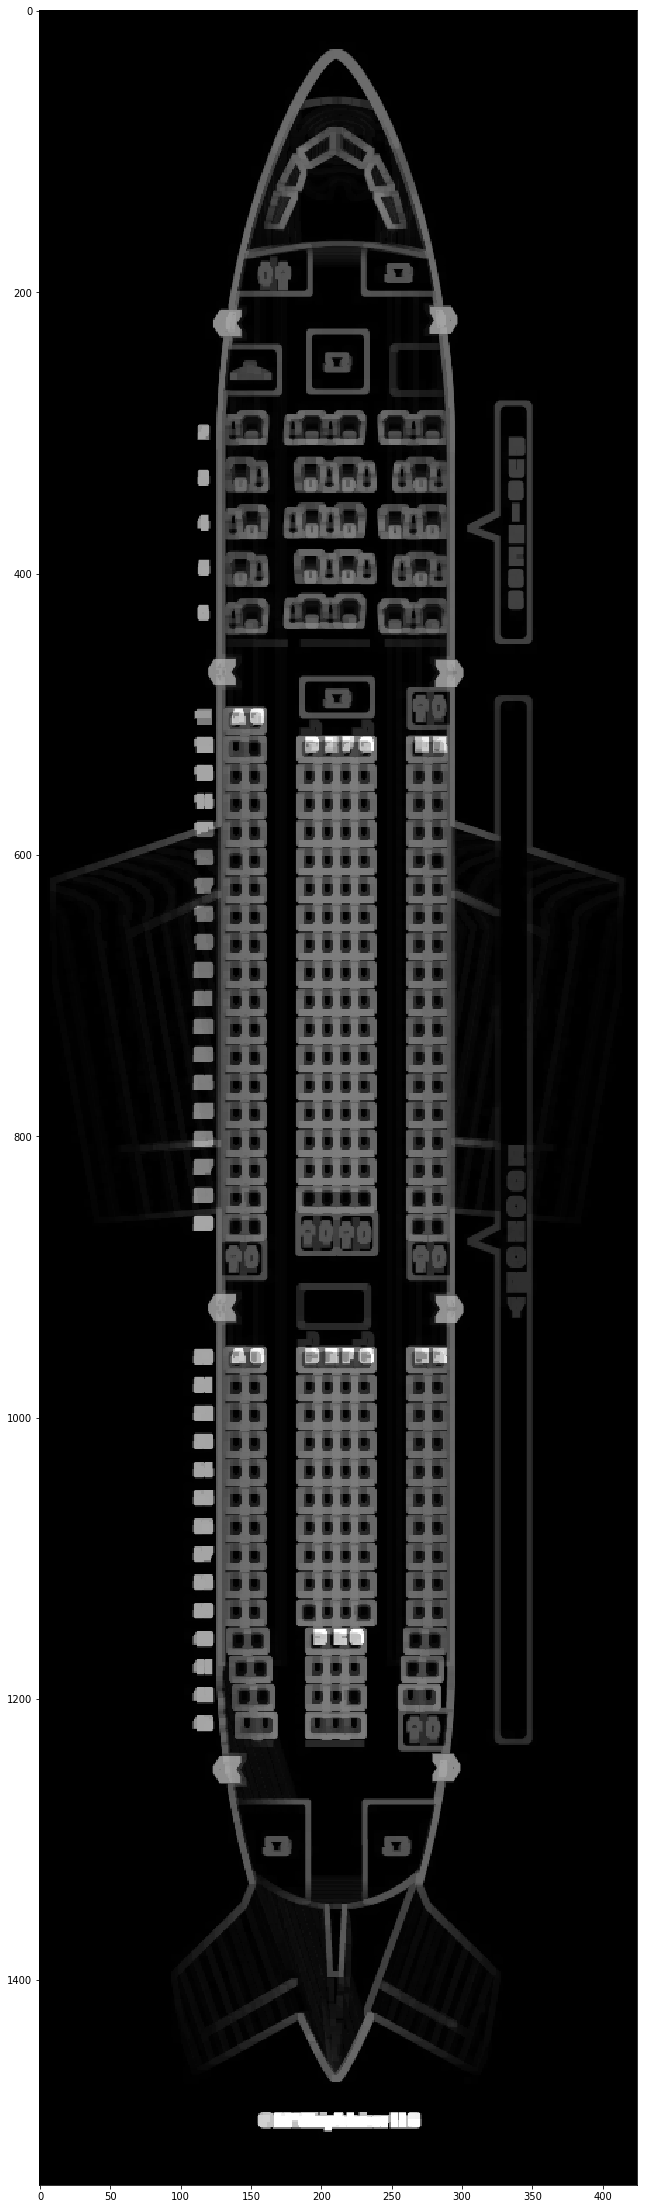

In [15]:
kernel = np.ones((5,5),np.uint8)
gradient = cv.morphologyEx(imgray, cv.MORPH_GRADIENT, kernel)
plt.figure(figsize=(20,40))
plt.imshow(gradient, cmap='gray')

## Top Hat

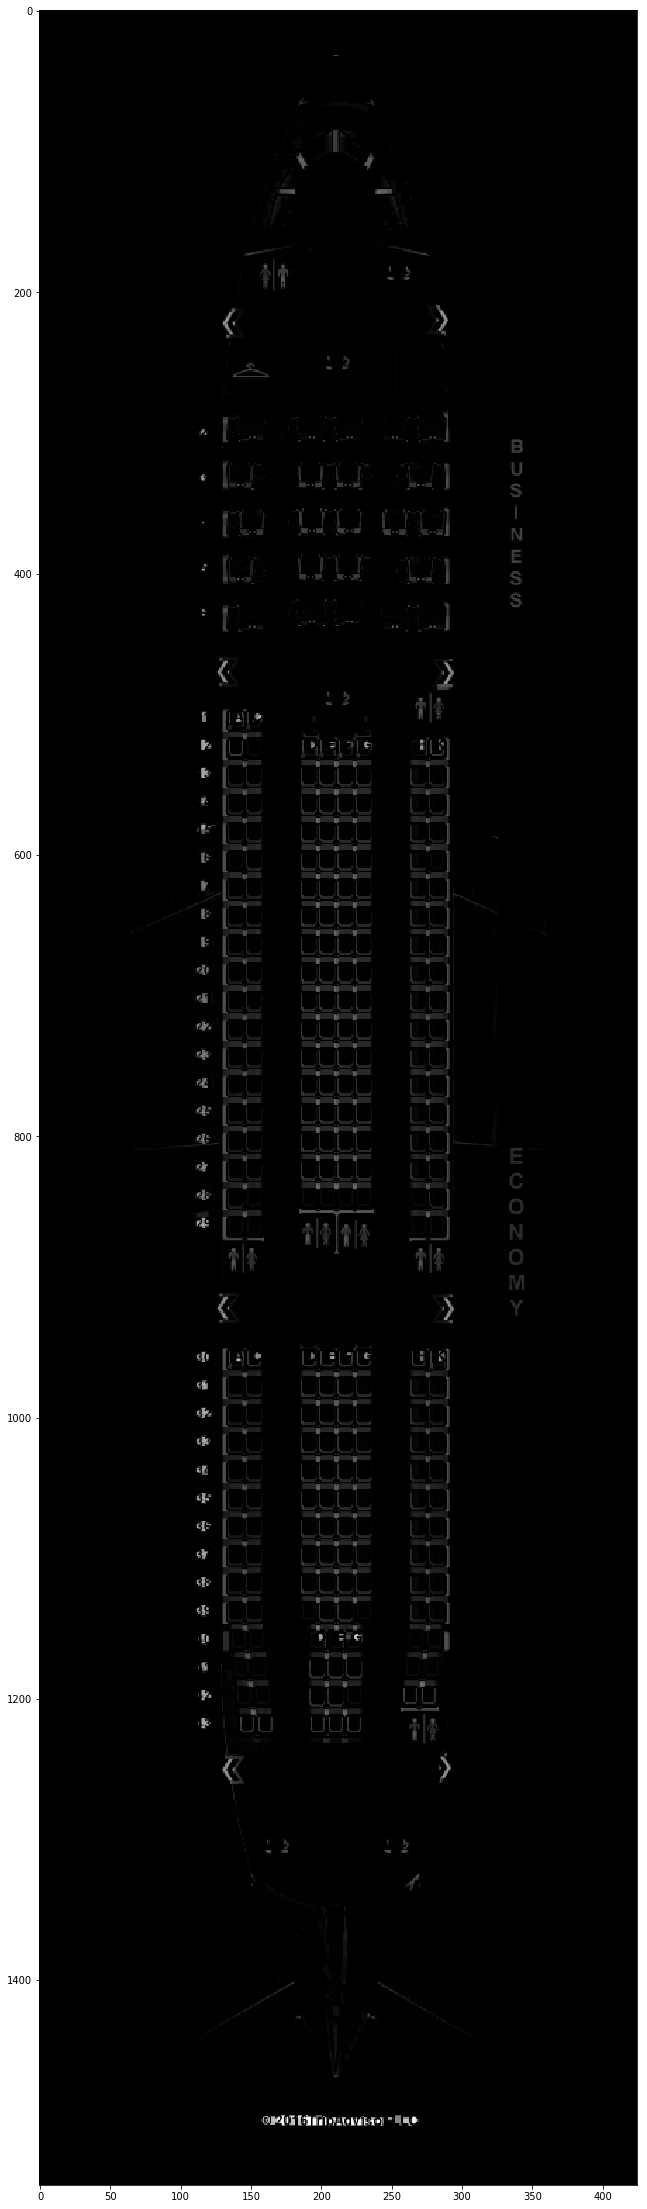

In [16]:
kernel = np.ones((5,5),np.uint8)
tophat = cv.morphologyEx(imgray, cv.MORPH_TOPHAT, kernel)
plt.figure(figsize=(20,40))
plt.imshow(tophat, cmap='gray')

## Black Hat

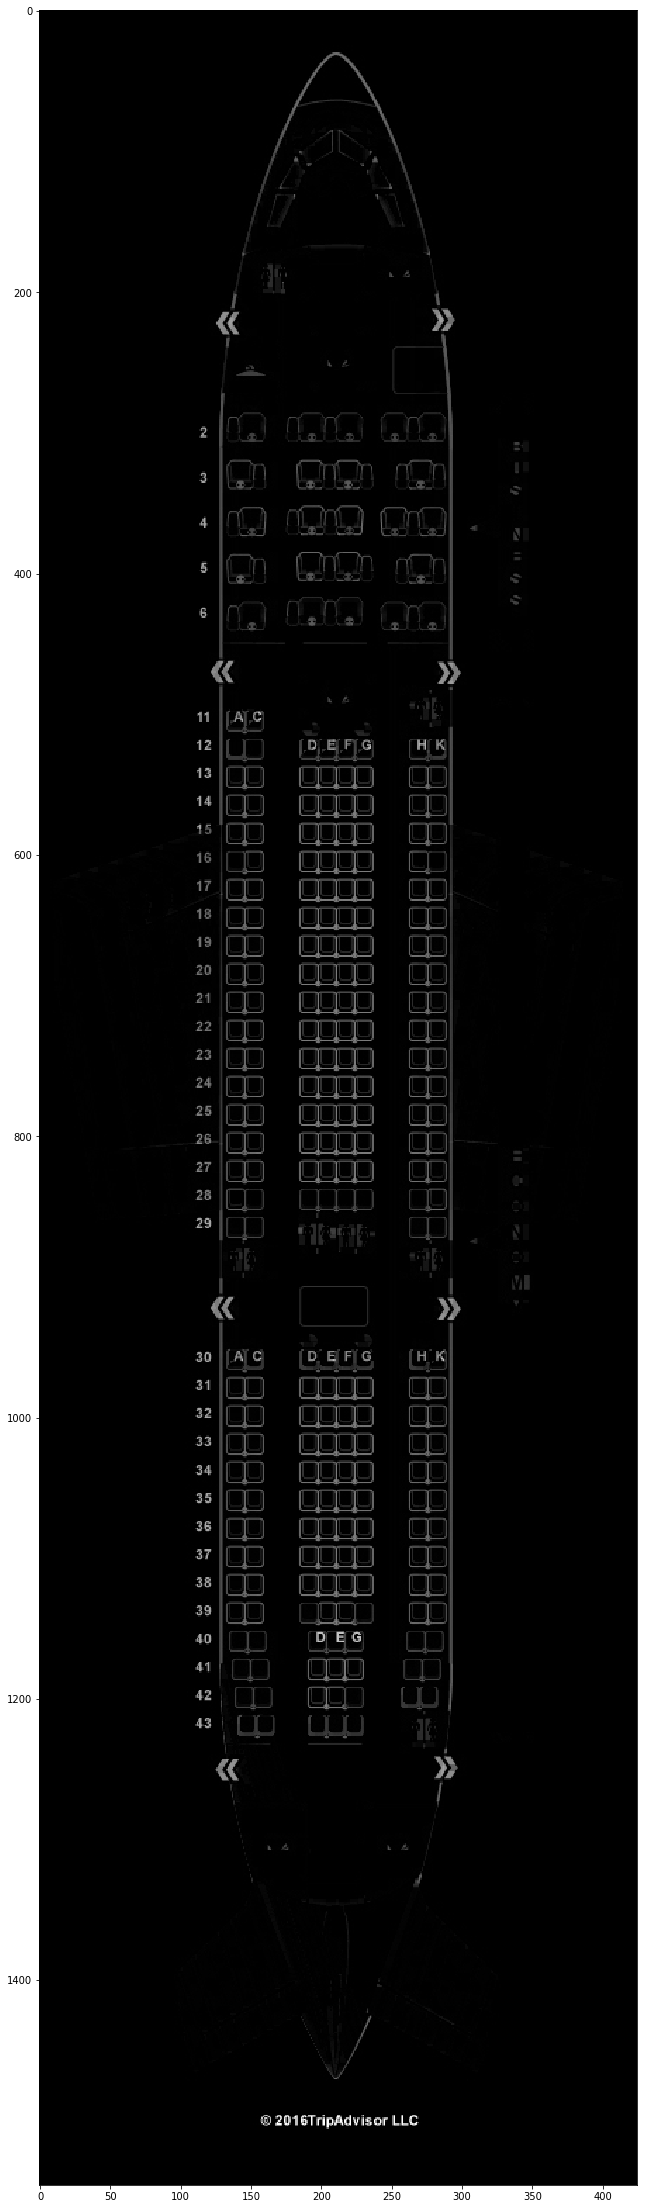

In [17]:
kernel = np.ones((5,5),np.uint8)
blackhat = cv.morphologyEx(imgray, cv.MORPH_BLACKHAT, kernel)
plt.figure(figsize=(20,40))
plt.imshow(blackhat, cmap='gray')